# Task "Health Insurance Dataset"

Cherednik Alexandra Gennadievna

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer

from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, KFold

from eli5 import show_weights

### Loading dataset from csv file

In [2]:
df = pd.read_csv('ds_internship_task/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Convert data to int type and create feature matrix 'x' and target vector 'y' 

In [4]:
y = df.charges.values

In [5]:
min(y), max(y)

(1121.8739, 63770.42801)

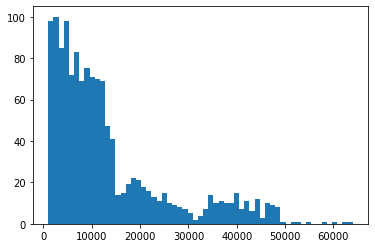

In [6]:
bins = np.linspace(1000, 64000, 60)
plt.hist(y, bins)
plt.show()

In [7]:
df['sex'] = df.sex.replace(['male','female'], [1,0]) # change feature 'sex' to int type (1 or 0)
df['smoker'] = df.smoker.replace(['yes','no'], [1,0]) # change feature 'smoker' to int type (1 or 0)

In [8]:
# look at the feature region
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [9]:
df_x = pd.get_dummies(df.iloc[:,:6]) # get_dummies converts categorical features into n bool (for each category)
x = df_x.values
x.shape

(1338, 9)

### Dividing the data into train and test sets

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=42) # random state to get same results every run

### Transformation of values

In [11]:
scaler = StandardScaler().fit(x_train) # standardize features by removing the mean and scaling to unit variance
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
qt = QuantileTransformer(output_distribution='normal') # transforms the features to follow a normal distribution
y_nd = qt.fit_transform(y_train.reshape(-1, 1)).flatten()
y_nd

array([-0.04828395, -0.13741404,  1.10459501, ...,  0.32190594,
        1.95919177,  0.08114773])

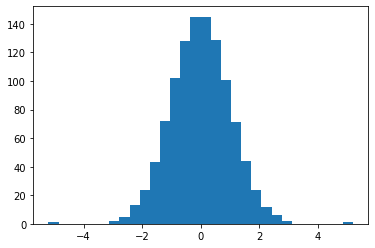

In [13]:
plt.hist(y_nd, bins=30)
plt.show()

### Regression

In [14]:
# grid with different parameters values for SGDRegressor
grid_regression = {'loss': ['squared_loss', 'huber','epsilon_insensitive'],
                   'penalty': ['l2', 'l1', 'elasticnet'],
                   'alpha': [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
                   'max_iter': [50, 100, 500, 800, 1000, 1200]
                  }

In [15]:
# joint enumeration of hyperparameters for training SGDRegressor
search_regr = GridSearchCV(SGDRegressor(random_state=33), param_grid=grid_regression, 
                           cv=KFold(5, random_state=33), # K-Folds cross-validator (to split data in train/validation sets)
                           verbose=1, scoring='neg_mean_absolute_error', n_jobs=-1)

In [16]:
search_regr.fit(x_train, y_nd)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    5.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=33, shuffl...
                                    tol=0.001, validation_fraction=0.1,
                                    verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive'],
               

In [17]:
model_regr = search_regr.best_estimator_ # best parameters

##### Predict of the model on a test set

In [18]:
predict_regr_nd = model_regr.predict(x_test) 
# predictions are in transformed format. need to be returned into original format

In [19]:
predict_regr = qt.inverse_transform(predict_regr_nd.reshape(-1,1)).flatten()
# inverse_transform returns prediction into original

##### The quality of the model

In [20]:
mean_absolute_error(y_test, predict_regr)

3330.66793389549

In [21]:
r2_score(y_test, predict_regr) # 1.0 is ideal

0.6688614494815224

##### The factors with the highest impact

In [22]:
feature_names = list(df_x.keys())

In [23]:
show_weights(model_regr, feature_names = feature_names) # weights of model

Weight?,Feature
+0.676,smoker
+0.590,age
+0.109,children
+0.029,bmi
+0.027,region_northeast
+0.009,region_northwest
-0.016,region_southwest
-0.019,region_southeast
-0.036,sex
-0.086,<BIAS>


### Decision Tree Regression

#### One more model to predict results. The same principle of operation

In [24]:
grid_tree = {'criterion': ['mse', 'friedman_mse', 'mae'],
             'max_depth': [1, 3, 5, 7, 10, 15, 18],
             'min_samples_split': [2, 5, 10, 15, 20],
             'min_samples_leaf': [1, 2, 5, 10, 15]
            }

In [25]:
search_tree = GridSearchCV(DecisionTreeRegressor(random_state=33), param_grid=grid_tree,cv=KFold(5, random_state=33), 
                           verbose=1, scoring='neg_mean_absolute_error', n_jobs=-1)

In [26]:
search_tree.fit(x_train,y_nd)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1354 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2625 out of 2625 | elapsed:   10.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=33,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 3, 5, 7, 10, 15, 18],
                     

In [27]:
model_tree = search_tree.best_estimator_

##### Predict of the model on a test set

In [28]:
predict_tree_nd = model_tree.predict(x_test)

In [29]:
predict_tree = qt.inverse_transform(predict_tree_nd.reshape(-1,1)).flatten()

##### The quality of the model

In [30]:
mean_absolute_error(y_test, predict_tree)

1592.2559473913975

In [31]:
r2_score(y_test, predict_tree)

0.8786905993948687

##### The factors with the highest impact

In [32]:
show_weights(model_tree, feature_names = feature_names, show = ['feature_importances'])

Weight,Feature
0.5138,age
0.3123,smoker
0.0756,bmi
0.0556,children
0.0152,sex
0.0102,region_northeast
0.0077,region_southwest
0.0054,region_southeast
0.0043,region_northwest


### Conclusion:
#### 1) The best implemented model gives results with a mean absolute error of ~1600 and a r2 score of ~0.87. Models with a r2 score above 0.8 can be considered quite good (the correlation coefficient exceeds 90%).
#### 2) The most impact factors are 'age' and 'smoker'

##### I tried also RandomForestRegressor, which gave the result a little less than Decision Tree Regression